In [1]:
import torch

import triton
import triton.language as tl


@triton.jit
def add_kernel(x_ptr, y_ptr, output_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    tl.store(output_ptr + offsets, output, mask=mask)


def add(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(x)
    assert x.is_cuda and y.is_cuda and output.is_cuda
    n_elements = x.numel()

    def grid(meta):
        return (triton.cdiv(n_elements, meta["BLOCK_SIZE"]),)

    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    return output

In [2]:
torch.manual_seed(42)
size = 98432
x = torch.rand(size, device="cuda")
y = torch.rand(size, device="cuda")

output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)


tensor([1.6007, 0.1390, 0.9605,  ..., 0.9873, 0.4830, 0.5993], device='cuda:0')
tensor([1.6007, 0.1390, 0.9605,  ..., 0.9873, 0.4830, 0.5993], device='cuda:0')


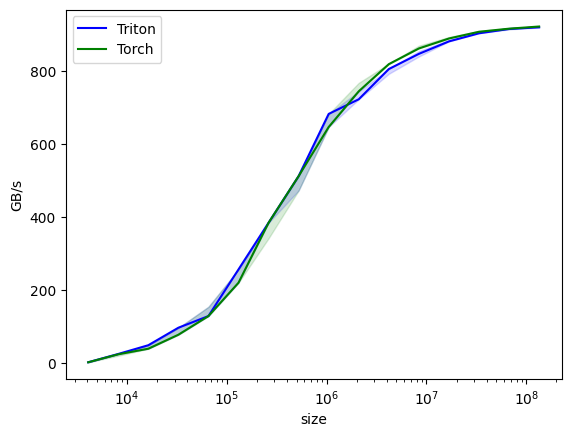

vector-add-performance:
           size      Triton       Torch
0        4096.0    1.200000    1.170732
1        8192.0   24.000000   23.097745
2       16384.0   48.000000   38.400001
3       32768.0   96.000000   76.800002
4       65536.0  127.999995  127.999995
5      131072.0  255.999991  219.428568
6      262144.0  384.000001  384.000001
7      524288.0  511.999982  511.999982
8     1048576.0  682.666643  646.736871
9     2097152.0  722.823517  744.727267
10    4194304.0  805.770507  819.200021
11    8388608.0  847.448255  862.315773
12   16777216.0  881.650242  889.628980
13   33554432.0  903.944839  908.120075
14   67108864.0  915.686951  916.587398
15  134217728.0  920.341734  922.517791


In [17]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["size"],
        x_vals=[2**i for i in range(12, 28, 1)],
        x_log=True,
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("blue", "-"), ("green", "-")],
        ylabel="GB/s",
        plot_name="vector-add-performance",
        args={},
    )
)
def benchmark(size, provider):
    x = torch.rand(size, device="cuda", dtype=torch.float32)
    y = torch.rand(size, device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    elif provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: add(x, y), quantiles=quantiles
        )

    def gbps(ms):
        return 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)

    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)

In [2]:
def native_softmax(x):
    x_max = x.max(dim=1)[0]
    z = x - x_max[:, None]
    numerator = torch.exp(z)
    denominator = numerator.sum(dim=1)
    return numerator / denominator[:, None]

In [3]:
@triton.jit
def softmax_kernel(
    output_ptr,
    input_ptr,
    input_row_stride,
    output_row_stride,
    n_rows,
    n_cols,
    BLOCK_SIZE: tl.constexpr,
    num_stages: tl.constexpr,
):
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        row_start_ptr = input_ptr + row_idx * input_row_stride
        col_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = row_start_ptr + col_offsets
        mask = col_offsets < n_cols
        row = tl.load(input_ptrs, mask=mask, other=-float("inf"))
        row_minus_max = row - tl.max(row, axis=0)
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator, axis=0)
        softmax_output = numerator / denominator
        output_row_ptr = output_ptr + row_idx * output_row_stride
        tl.store(output_row_ptr + col_offsets, softmax_output, mask=mask)


device = torch.cuda.current_device()
properties = triton.runtime.driver.active.utils.get_device_properties(device)
SIZE_SMEM = properties["max_shared_mem"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
NUM_SM = properties["multiprocessor_count"]
kernels = {}


def softmax(x):
    n_rows, n_cols = x.shape
    BLOCK_SIZE = triton.next_power_of_2(n_cols)
    num_warps = 8
    num_stages = 4 if SIZE_SMEM > 2e5 else 2
    y = torch.empty_like(x)
    kernel, num_programs = kernels.get(BLOCK_SIZE, (None, 0))
    if kernel is None:
        kernel = softmax_kernel.warmup(
            y,
            x,
            x.stride(0),
            y.stride(0),
            n_rows,
            n_cols,
            BLOCK_SIZE=BLOCK_SIZE,
            num_stages=num_stages,
            num_warps=num_warps,
            grid=(1,),
        )
        kernel._init_handles()
        n_regs = kernel.n_regs
        size_smem = kernel.metadata.shared
        occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
        occupancy = min(occupancy, SIZE_SMEM // size_smem)
        num_programs = NUM_SM * occupancy
        kernels[BLOCK_SIZE] = (kernel, num_programs)
    num_programs = min(num_programs, n_rows)
    kernel[(num_programs, 1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols)
    return y


In [4]:
x = torch.randn(1000, 1000, device="cuda")
y_triton = softmax(x)
y_torch = native_softmax(x)
torch.allclose(y_triton, y_torch)

True

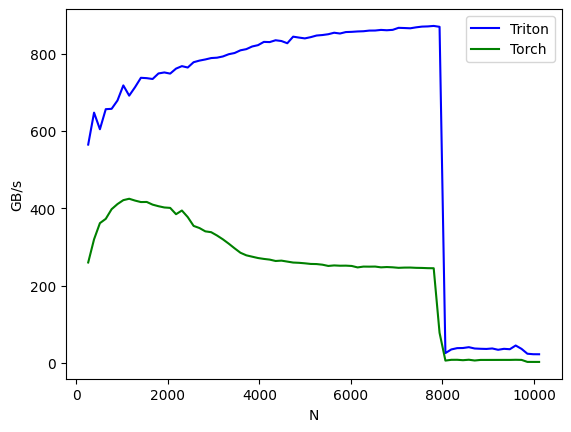

softmax-performance:
          N      Triton       Torch
0     256.0  565.041171  260.246747
1     384.0  647.687938  320.123849
2     512.0  604.762313  361.949027
3     640.0  656.648891  373.072799
4     768.0  657.550225  398.046748
5     896.0  679.104232  411.261969
6    1024.0  718.123176  421.412584
7    1152.0  691.642441  425.008775
8    1280.0  713.531501  420.272770
9    1408.0  737.795651  416.475375
10   1536.0  736.848945  416.713925
11   1664.0  734.677480  409.798900
12   1792.0  749.002992  405.732495
13   1920.0  751.611373  402.478348
14   2048.0  748.619403  401.395171
15   2176.0  761.536377  385.086047
16   2304.0  767.931061  394.589706
17   2432.0  764.350414  377.583595
18   2560.0  778.079044  354.815433
19   2688.0  782.258149  349.290119
20   2816.0  785.204719  340.734049
21   2944.0  788.809697  338.541682
22   3072.0  789.782080  329.959888
23   3200.0  792.946405  320.099050
24   3328.0  798.761400  308.892357
25   3456.0  801.878758  296.846525
26   35

In [5]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["N"],
        x_vals=[128 * i for i in range(2, 80)],
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("blue", "-"), ("green", "-")],
        ylabel="GB/s",
        plot_name="softmax-performance",
        args={"M": 4096},
    )
)
def benchmark(M, N, provider):
    x = torch.randn(M, N, device="cuda", dtype=torch.float32)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == "torch":
        ms = triton.testing.do_bench(lambda: native_softmax(x))
    elif provider == "triton":
        ms = triton.testing.do_bench(lambda: softmax(x))

    def gbps(ms):
        return 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)

    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)